<h1>NFL Betting Project: Point Total Prediction Model</h1>

In [2]:
# author: Warren Blood
# last update: 11-23-2021

In [384]:
# import packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score

<h3>Data Import</h3>

In [451]:
# import preprocessed game data csv file
data = pd.read_csv('Preprocessed Game Data.csv', sep=',', encoding='unicode_escape')
# check for any missing values in data
print('Number of missing values in data: ' + str(sum(data.isnull().sum())))
data.head()

Number of missing values in data: 0


,indoor_stadium,divisional,AT&T Stadium,Allegiant Stadium,Arrowhead Stadium,Azteca Stadium,Bank of America Stadium,Caesars Superdome,Candlestick Park,Edward Jones Dome,...,home_margin_o_u,away_margin_o_u,home_margin_ats,away_margin_ats,point_total,vegas_over_under,hit_over,home_min_away_spread,vegas_home_min_away_spread,home_covered_spread
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,0.0,-4.0,0.0,44.0,39.0,1.0,-18.0,-6.5,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,1.0,5.0,61.0,51.0,1.0,1.0,3.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,-5.0,3.0,52.0,40.0,1.0,-32.0,-14.5,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-5.0,-1.0,3.0,-1.0,40.0,39.0,1.0,6.0,7.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,4.0,-1.0,0.0,44.0,46.5,0.0,10.0,5.5,1.0


In [452]:
# drop columns from data that contains info not available prior to kickoff to create feature space X
X = data.drop(['point_total', 'hit_over', 'home_min_away_spread', 'home_covered_spread'], axis=1)

# additionally, drop OHE features without sufficient presence in dataset or that are no longer relevant (i.e. retired head 
# coaches & first-time head coaches with few examples in dataset)
X = X.drop(['Allegiant Stadium','Azteca Stadium','Candlestick Park','Edward Jones Dome','Georgia Dome',
            'Los Angeles Memorial Coliseum','Mall of America Field','Qualcomm Stadium','Ring Central Coliseum',
            'SoFi Stadium','StubHub Center','TCF Bank Stadium','Tottenham Stadium','Twickenham Stadium',
            'Wembley Stadium','home_coach Adam Gase','home_coach Anthony Lynn','home_coach Arthur Smith',
            'home_coach Ben McAdoo','home_coach Bill Callahan',"home_coach Bill O'Brien",'home_coach Brandon Staley',
            'home_coach Brian Flores','home_coach Chip Kelly','home_coach Chuck Pagano','home_coach Dan Campbell',
            'home_coach Dan Quinn','home_coach Darrell Bevell','home_coach David Culley','home_coach Dennis Allen',
            'home_coach Dirk Koetter','home_coach Doug Marrone','home_coach Doug Pederson','home_coach Freddie Kitchens',
            'home_coach Gary Kubiak','home_coach Greg Schiano','home_coach Gregg Williams','home_coach Gus Bradley',
            'home_coach Hue Jackson','home_coach Jack Del Rio','home_coach Jason Garrett','home_coach Jay Gruden',
            'home_coach Jeff Fisher','home_coach Jim Caldwell','home_coach Jim Harbaugh','home_coach Jim Schwartz',
            'home_coach Jim Tomsula','home_coach Joe Judge','home_coach Joe Philbin','home_coach John Fassel',
            'home_coach John Fox','home_coach Jon Gruden','home_coach Ken Whisenhunt','home_coach Kevin Stefanski',
            'home_coach Kliff Kingsbury','home_coach Leslie Frazier','home_coach Lovie Smith','home_coach Marc Trestman',
            'home_coach Marvin Lewis','home_coach Matt LaFleur','home_coach Matt Nagy','home_coach Matt Patricia',
            'home_coach Matt Rhule','home_coach Mike McCoy','home_coach Mike Mularkey','home_coach Mike Munchak',
            'home_coach Mike Pettine','home_coach Mike Shanahan','home_coach Mike Smith','home_coach Nick Sirianni',
            'home_coach Pat Shurmur','home_coach Perry Fewell','home_coach Raheem Morris','home_coach Rex Ryan',
            'home_coach Rob Chudzinski','home_coach Robert Saleh','home_coach Romeo Crennel','home_coach Steve Spagnuolo',
            'home_coach Steve Wilks','home_coach Todd Bowles','home_coach Tom Coughlin','home_coach Tony Sparano',
            'home_coach Urban Meyer','home_coach Vance Joseph','home_coach Vic Fangio','home_coach Wade Phillips',
            'home_coach Zac Taylor','away_coach Adam Gase','away_coach Anthony Lynn','away_coach Arthur Smith',
            'away_coach Ben McAdoo','away_coach Bill Callahan',"away_coach Bill O'Brien",'away_coach Brandon Staley',
            'away_coach Brian Flores','away_coach Chip Kelly','away_coach Chuck Pagano','away_coach Dan Campbell',
            'away_coach Dan Quinn','away_coach Darrell Bevell','away_coach David Culley','away_coach Dennis Allen',
            'away_coach Dirk Koetter','away_coach Doug Marrone','away_coach Doug Pederson','away_coach Freddie Kitchens',
            'away_coach Gary Kubiak','away_coach Greg Schiano','away_coach Gregg Williams','away_coach Gus Bradley',
            'away_coach Hue Jackson','away_coach Jack Del Rio','away_coach Jason Garrett','away_coach Jay Gruden',
            'away_coach Jeff Fisher','away_coach Jim Caldwell','away_coach Jim Harbaugh','away_coach Jim Schwartz',
            'away_coach Jim Tomsula','away_coach Joe Judge','away_coach Joe Philbin','away_coach John Fassel',
            'away_coach John Fox','away_coach Jon Gruden','away_coach Ken Whisenhunt','away_coach Kevin Stefanski',
            'away_coach Kliff Kingsbury','away_coach Leslie Frazier','away_coach Lovie Smith','away_coach Marc Trestman',
            'away_coach Marvin Lewis','away_coach Matt LaFleur','away_coach Matt Nagy','away_coach Matt Patricia',
            'away_coach Matt Rhule','away_coach Mike McCoy','away_coach Mike Mularkey','away_coach Mike Munchak',
            'away_coach Mike Pettine','away_coach Mike Shanahan','away_coach Mike Smith','away_coach Nick Sirianni',
            'away_coach Pat Shurmur','away_coach Perry Fewell','away_coach Raheem Morris','away_coach Rex Ryan',
            'away_coach Rob Chudzinski','away_coach Robert Saleh','away_coach Romeo Crennel','away_coach Steve Spagnuolo',
            'away_coach Steve Wilks','away_coach Todd Bowles','away_coach Tom Coughlin','away_coach Tony Sparano',
            'away_coach Urban Meyer','away_coach Vance Joseph','away_coach Vic Fangio','away_coach Wade Phillips',
            'away_coach Zac Taylor'], axis=1)

# target column y
y = data['hit_over']

In [453]:
for i in (X.columns):
    print(str(i) + ': ' + str(sum(X[i])))

indoor_stadium: 541.0
divisional: 742.0
AT&T Stadium: 62.0
Arrowhead Stadium: 61.0
Bank of America Stadium: 64.0
Caesars Superdome: 62.0
Empower Field at Mile High: 63.0
FedExField: 63.0
FirstEnergy Stadium: 61.0
Ford Field: 63.0
Gillette Stadium: 63.0
Hard Rock Stadium: 61.0
Heinz Field: 64.0
Highmark Stadium: 60.0
Lambeau Field: 64.0
Levi's Stadium: 54.0
Lincoln Financial Field: 64.0
Lucas Oil Stadium: 63.0
Lumen Field: 64.0
M&T Bank Stadium: 62.0
Mercedes-Benz Stadium: 34.0
MetLife Stadium: 124.0
NRG Stadium: 63.0
Nissan Stadium: 61.0
Paul Brown Stadium: 63.0
Raymond James Stadium: 61.0
Soldier Field: 62.0
State Farm Stadium: 66.0
TIAA Bank Field: 57.0
U.S. Bank Stadium: 42.0
temp: 125120.0
humidity: 1137.060000000013
wind_speed: 11922.0
home_coach Andy Reid: 62.0
home_coach Bill Belichick: 63.0
home_coach Bruce Arians: 54.0
home_coach Frank Reich: 26.0
home_coach John Harbaugh: 62.0
home_coach Kyle Shanahan: 33.0
home_coach Mike McCarthy: 55.0
home_coach Mike Tomlin: 64.0
home_coac

<h3>Split Data</h3>

In [454]:
# Split data into 80/20 training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [455]:
# k-Fold validation split do perform throughout model selection
kf = KFold(n_splits=10, shuffle=True, random_state=5)

<h2>Model 1: Random Forest Classifier</h2>

In [13]:
# Random Forest Classifier Hyperparameters Tuned:
# - n_estimators: Number of trees in forest
# - max_depth: Maximum number of levels in tree
# - min_samples_split: Minimum number of samples required to split an internal node
# - min_samples_leaf: Minimum number of samples required to be at a leaf node
# - max_features: Number of features to consider when looking for the best split
# - max_leaf_nodes: Maximum number of leaf nodes

<h3>1.1: No Feature Selection/Extraction</h3>

In [14]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [25]:
scaler = StandardScaler()
forest = RandomForestClassifier(n_jobs=-1, random_state=5)

parameters = dict(n_estimators=np.arange(100, 1001, 100), max_depth=np.arange(5,16,1), min_samples_split=np.arange(2,6,1), 
                     min_samples_leaf=np.arange(1,16,1), max_features=['auto','sqrt','log2'], max_leaf_nodes=np.arange(10,80,5))

search = RandomizedSearchCV(estimator=forest, param_distributions=parameters, n_iter=50, scoring='balanced_accuracy', 
                            n_jobs=-1, cv=kf, random_state=5)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [26]:
best_params

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 60,
 'max_features': 'sqrt',
 'max_depth': 11}

In [30]:
scaler = StandardScaler()
forest = RandomForestClassifier(n_estimators = 500, max_depth=11, min_samples_split=2, min_samples_leaf=7, 
                                max_features='sqrt', max_leaf_nodes=60, random_state=5)
val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    forest.fit(x_trn, y_trn)
    val_pred_values = forest.predict(x_val)
    trn_pred_values = forest.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.9988417147055341
k-Fold Cross-Validation Balanced Accuracy: 0.5107673961671886


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5113614026561302 (0.9988417147055341)

**Feature Scale Function:** MinMaxScaler()

**Hyperparameters:** n_estimators=500, max_depth=11, min_samples_split=2, min_samples_leaf=7, max_features='sqrt', max_leaf_nodes=60

<h3>1.2: Feature Extraction by PCA</h3>

In [44]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [27]:
best_cv_score = 0
best_params = dict()
best_n_components = 0

scaler = StandardScaler()
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters = dict(n_estimators=np.arange(100, 1001, 100), max_depth=np.arange(5,16,1), min_samples_split=np.arange(2,6,1), 
                     min_samples_leaf=np.arange(1,16,1), max_features=['auto','sqrt','log2'], max_leaf_nodes=np.arange(2,48,3))

for i in range(len(components)):
    pca = PCA(n_components=components[i], random_state=5)
    forest = RandomForestClassifier(n_jobs=-1, random_state=5)
    
    search = RandomizedSearchCV(estimator=forest, param_distributions=parameters, n_iter=50, scoring='balanced_accuracy', 
                            n_jobs=-1, cv=kf, random_state=5)
    
    pipeline = Pipeline(steps=[('scale', scaler), ('pca', pca), ('search', search)])
    pipeline.fit(X_train, y_train)
    
    if(search.best_score_ > best_cv_score):
        best_cv_score = search.best_score_
        best_params = search.best_params_
        best_n_components = components[i]

In [28]:
best_params

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 11,
 'max_leaf_nodes': 47,
 'max_features': 'auto',
 'max_depth': 9}

In [29]:
best_n_components

3

In [31]:
scaler = StandardScaler()
forest = RandomForestClassifier(n_estimators = 600, max_depth=9, min_samples_split=2, min_samples_leaf=11, 
                                max_features='auto', max_leaf_nodes=47, random_state=5)

pca = PCA(n_components=3, random_state=5)
val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    forest.fit(PCA_x_trn, y_trn)
    val_pred_values = forest.predict(PCA_x_val)
    trn_pred_values = forest.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.7546154425843684
k-Fold Cross-Validation Balanced Accuracy: 0.517180114790541


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.517180114790541 (0.7546154425843684)

**Feature Scale Function:** StandardScaler()

**PCA n_components:** 3

**Hyperparameters:** n_estimators=600, max_depth=9, min_samples_split=2, min_samples_leaf=11, max_features='auto', max_leaf_nodes=47

<h3>1.3: Feature Selection by Recursive Feature Elimination</h3>

In [47]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [32]:
scaler = MinMaxScaler()
# There is no cross-validation estimator for RandomForestClassifier, so to have reasonable time efficiency we will
# only set a few hyperparameters of the random forest for RFE. We will then tune hyperparameters separately after RFE
forest = RandomForestClassifier(n_estimators = 300, max_depth=15, max_leaf_nodes=20, random_state=5)

selector = RFECV(estimator=forest, step=1, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', scaler), ('selector', selector)])
pipeline.fit(X_train, y_train)

feat_ranks = selector.ranking_

In [33]:
sel_feat_i = np.where(feat_ranks==1)[0]
feat_names=[]
for i in sel_feat_i:
    feat_names.append(X_train.columns[i])
feat_names

['away_avg_pos_time',
 'home_off_pen_yds',
 'away_off_pen_yds',
 'home_def_pen_yds',
 'away_def_pen_yds',
 'home_off_rush_ypc',
 'away_off_rush_ypc',
 'home_off_any_a',
 'away_off_any_a',
 'home_def_any_a',
 'away_def_any_a',
 'home_off_epr',
 'away_off_epr',
 'away_def_epr',
 'away_off_edps',
 'away_def_edps',
 'home_off_edrs',
 'away_off_edrs',
 'away_def_edrs',
 'home_off_int_rate',
 'home_def_int_rate',
 'away_def_int_rate',
 'home_def_yppr',
 'away_def_yppr',
 'away_off_ypkr',
 'away_def_ypkr',
 'home_off_avg_sfp',
 'away_off_avg_sfp',
 'home_def_avg_sfp',
 'home_off_spcr',
 'home_def_spcr',
 'away_def_spcr',
 'away_def_dpcr',
 'home_off_tdcr',
 'away_off_tdcr',
 'home_def_tdcr',
 'away_off_fdcr',
 'away_def_rze',
 'home_def_pts_100']

In [169]:
feat_names = ['home_off_pen_yds', 'home_def_pen_yds', 'away_def_pen_yds', 'home_off_any_a', 'home_def_int_rate', 
              'away_off_ypkr', 'away_off_avg_sfp', 'home_def_spcr', 'away_def_spcr', 'away_def_dpcr', 'home_def_pts_100']

In [170]:
FS_x_train = X_train[feat_names]

scaler = MinMaxScaler()
forest = RandomForestClassifier(n_jobs=-1, random_state=5)

parameters = dict(n_estimators=np.arange(100, 1001, 100), max_depth=np.arange(5,16,1), min_samples_split=np.arange(2,6,1), 
                     min_samples_leaf=np.arange(1,16,1), max_features=['auto','sqrt','log2'], max_leaf_nodes=np.arange(2,48,3))

search = RandomizedSearchCV(estimator=forest, param_distributions=parameters, n_iter=50, scoring='balanced_accuracy', 
                            n_jobs=-1, cv=kf, random_state=5)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(FS_x_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

KeyboardInterrupt: 

In [ ]:
best_params

In [38]:
scaler = MinMaxScaler()
forest = RandomForestClassifier(n_estimators = 400, max_depth=13, min_samples_split=5, min_samples_leaf=7, 
                                max_features='log2', max_leaf_nodes=32, random_state=5)
FS_x_train = X_train[feat_names]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    forest.fit(x_trn, y_trn)
    val_pred_values = forest.predict(x_val)
    trn_pred_values = forest.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.9416770548817418
k-Fold Cross-Validation Balanced Accuracy: 0.5236852735248468


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5236852735248468 (0.9416770548817418)

**Feature Scale Function:** MinMaxScaler()

**Features Selected:** ['away_avg_pos_time','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_pen_yds',
'home_off_rush_ypc','away_off_rush_ypc','home_off_any_a','away_off_any_a','home_def_any_a','away_def_any_a','home_off_epr',
'away_off_epr','away_def_epr','away_off_edps','away_def_edps','home_off_edrs','away_off_edrs','away_def_edrs','home_off_int_rate','home_def_int_rate','away_def_int_rate','home_def_yppr','away_def_yppr','away_off_ypkr','away_def_ypkr','home_off_avg_sfp','away_off_avg_sfp','home_def_avg_sfp','home_off_spcr','home_def_spcr','away_def_spcr','away_def_dpcr','home_off_tdcr','away_off_tdcr','home_def_tdcr','away_off_fdcr','away_def_rze','home_def_pts_100']

**Hyperparameters:** n_estimators=400, max_depth=13, min_samples_split=5, min_samples_leaf=7, max_features='log2', max_leaf_nodes=32

*RFECV run with forest of n_estimators=300, max_depth=15, max_leaf_nodes=20

<h2>Model 2: Neural Network</h2>

In [70]:
# Neural Network Regressor Hyperparameters Tuned:
# - hidden_layer_sizes: (tuple) ith element represents the number of neurons in the ith hidden layer
# - activation: Activation function for the hidden layer
# - alpha: L2 penalty parameter

<h3>2.1: No Feature Selection/Extraction</h3>

In [82]:
# hidden_layer_sizes=[(15,),(25,),(35,),(45,),(55,),(65,),(75,),(85,),(95,),(125,),(150,),(175,),(200,)]
# hidden_layer_sizes=[(25,45),(45,25),(25,65),(65,25),(25,85),(85,25),(45,65),(65,45),(45,85),(85,45),(65,85),
#                     (85,65),(25,25),(45,45),(65,65),(85,85)]

In [83]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [80]:
scaler = StandardScaler()
model = MLPClassifier(max_iter=500, random_state=5)

parameters = dict(hidden_layer_sizes=[(15,),(25,),(35,),(45,),(55,),(65,),(75,),(85,),(95,),(125,),(150,),(175,),(200,)], 
                  activation=['identity', 'logistic', 'tanh', 'relu'], 
                  alpha=[0.0005, 0.005, 0.05, 0.5, 5])

search = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_iter=50, scoring='balanced_accuracy', 
                            n_jobs=-1, cv=kf, random_state=5)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [81]:
best_params

{'hidden_layer_sizes': (35,), 'alpha': 0.0005, 'activation': 'tanh'}

In [11]:
scaler = MinMaxScaler()
model = MLPClassifier(hidden_layer_sizes=(45,), activation= 'tanh', alpha=0.05, max_iter=500, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.7057609852179512
k-Fold Cross-Validation Balanced Accuracy: 0.5318959286766164


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5318959286766164 (0.7057609852179512)

**Feature Scale Function:** MinMaxScaler()

**Hyperparameters:** hidden_layer_sizes=(45,), activation='tanh', alpha=0.05

<h3>2.2: Feature Extraction by PCA</h3>

In [87]:
# hidden_layer_sizes=[(15,),(25,),(35,),(45,),(55,),(65,),(75,),(85,),(95,),(125,),(150,),(175,),(200,)]
# hidden_layer_sizes=[(25,45),(45,25),(25,65),(65,25),(25,85),(85,25),(45,65),(65,45),(45,85),(85,45),(65,85),
#                     (85,65),(25,25),(45,45),(65,65),(85,85)]

In [94]:
best_cv_score = 0
best_params = dict()
best_n_components = 0

scaler = StandardScaler()
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters = dict(hidden_layer_sizes=[(25,45),(45,25),(25,65),(65,25),(25,85),(85,25),(45,65),(65,45),(45,85),(85,45),(65,85),
                                      (85,65),(25,25),(45,45),(65,65),(85,85)], 
                  activation=['identity', 'logistic', 'tanh', 'relu'], 
                  alpha=[0.0005, 0.005, 0.05, 0.5, 5])

for i in range(len(components)):
    pca = PCA(n_components=components[i], random_state=5)
    model = MLPClassifier(max_iter=500, random_state=5)
    
    search = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_iter=50, scoring='balanced_accuracy', 
                            n_jobs=-1, cv=kf, random_state=5)
    
    pipeline = Pipeline(steps=[('scale', scaler), ('pca', pca), ('search', search)])
    pipeline.fit(X_train, y_train)
    
    if(search.best_score_ > best_cv_score):
        best_cv_score = search.best_score_
        best_params = search.best_params_
        best_n_components = components[i]

C:\Users\Warren\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [95]:
best_params

{'hidden_layer_sizes': (25, 65), 'alpha': 0.0005, 'activation': 'relu'}

In [96]:
best_n_components

3

In [12]:
scaler = StandardScaler()
model = MLPClassifier(hidden_layer_sizes=(25,65), activation= 'relu', alpha=0.5, max_iter=1000, random_state=5)
pca = PCA(n_components=3, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    model.fit(PCA_x_trn, y_trn)
    val_pred_values = model.predict(PCA_x_val)
    trn_pred_values = model.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.5794543232136716
k-Fold Cross-Validation Balanced Accuracy: 0.5431316799679766


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5431316799679766 (0.5794543232136716)

**Feature Scale Function:** StandardScaler()

**PCA n_components:** 3

**Hyperparameters:** hidden_layer_sizes=(25,65), activation='relu', alpha=0.5, max_iter=1000

<h3>2.3: Feature Selection (Features From 1.3 & 3.3)</h3>

In [110]:
# hidden_layer_sizes=[(15,),(25,),(35,),(45,),(55,),(65,),(75,),(85,),(95,),(125,),(150,),(175,),(200,)]
# hidden_layer_sizes=[(25,45),(45,25),(25,65),(65,25),(25,85),(85,25),(45,65),(65,45),(45,85),(85,45),(65,85),
#                     (85,65),(25,25),(45,45),(65,65),(85,85)]

In [173]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [174]:
feat_names = ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field',
              'Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
              'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
              'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
              'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']

In [189]:
FS_x_train = X_train[feat_names]

scaler = MinMaxScaler()
model = MLPClassifier(max_iter=500, random_state=5)

parameters = dict(hidden_layer_sizes=[(15,),(23,),(24,),(25,),(30,)],
                  activation=['identity'], 
                  alpha=[0.0005, 0.005, 0.05])

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(FS_x_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [190]:
best_params

{'activation': 'identity', 'alpha': 0.0005, 'hidden_layer_sizes': (25,)}

In [191]:
scaler = MinMaxScaler()
model = MLPClassifier(hidden_layer_sizes=(25,), activation='identity', alpha=0.0005, max_iter=1000, random_state=5)

FS_x_train = X_train[feat_names]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6110872136225007
k-Fold Cross-Validation Balanced Accuracy: 0.5807422479622489


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5975189254686442 (0.6130249495604632)

**Feature Scale Function:** StandardScaler()

**Features Selected:** ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field','Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']

**Hyperparameters:** hidden_layer_sizes=(65,), activation='identity', alpha=0.07

<h2>Model 3: Ridge Classifier</h2>

In [138]:
# Ridge Classifier Hyperparameters Tuned:
# - alpha: Constant multiplied by regularization term (regularization strength)

<h3>3.1: No Feature Selection/Extraction</h3>

In [39]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [43]:
scaler = StandardScaler()
model = RidgeClassifier(random_state=5)

parameters = dict(alpha=np.arange(1,101,1))

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [44]:
best_params

{'alpha': 99}

In [168]:
scaler = MinMaxScaler()
model = RidgeClassifier(alpha=37, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6190701335474399
k-Fold Cross-Validation Balanced Accuracy: 0.5043317375434575


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5043317375434575 (0.6190701335474399)

**Feature Scale Function:** MinMaxScaler()

**Hyperparameters:** alpha=37

<h3>3.2: Feature Extraction by PCA</h3>

In [170]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [50]:
best_cv_score = 0
best_params = dict()
best_n_components = 0

scaler = StandardScaler()
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters = dict(alpha=[0.0005, 0.005, 0.05, 0.5, 5])

for i in range(len(components)):
    pca = PCA(n_components=components[i], random_state=5)
    model = RidgeClassifier(random_state=5)
    
    search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)
    
    pipeline = Pipeline(steps=[('scale', scaler), ('pca', pca), ('search', search)])
    pipeline.fit(X_train, y_train)
    
    if(search.best_score_ > best_cv_score):
        best_cv_score = search.best_score_
        best_params = search.best_params_
        best_n_components = components[i]

In [51]:
best_params

{'alpha': 0.0005}

In [52]:
best_n_components

3

In [167]:
scaler = MinMaxScaler()
model = RidgeClassifier(alpha=0.0005, random_state=5)
pca = PCA(n_components=2, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    model.fit(PCA_x_trn, y_trn)
    val_pred_values = model.predict(PCA_x_val)
    trn_pred_values = model.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.5079025544228422
k-Fold Cross-Validation Balanced Accuracy: 0.4995400176571462


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.4995400176571462 (0.5079025544228422)

**Feature Scale Function:** MinMaxScaler()

**PCA n_components:** 2

**Hyperparameters:** alpha=0.0005

<h3>3.3: Feature Selection by Recursive Feature Elimination</h3>

In [169]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [154]:
scaler = StandardScaler()

modelCV = RidgeClassifierCV(alphas=[0.0005, 0.005, 0.05, 0.5, 1, 2, 5, 10, 20, 50], scoring='balanced_accuracy', cv=kf)

selector = RFECV(estimator=modelCV, step=1, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', scaler), ('selector', selector)])
pipeline.fit(X_train, y_train)

feat_ranks = selector.ranking_

In [156]:
sel_feat_i = np.where(feat_ranks==1)[0]
feat_names=[]
for i in sel_feat_i:
    feat_names.append(X_train.columns[i])
feat_names

['divisional',
 'Arrowhead Stadium',
 'Caesars Superdome',
 'Lambeau Field',
 "Levi's Stadium",
 'Lincoln Financial Field',
 'Lucas Oil Stadium',
 'Soldier Field',
 'State Farm Stadium',
 'home_coach Bruce Arians',
 'home_coach Frank Reich',
 'home_coach Kyle Shanahan',
 'home_coach Mike McCarthy',
 'away_coach Mike Tomlin',
 'away_coach Sean McDermott',
 'home_off_pen_yds',
 'away_off_pen_yds',
 'home_def_pen_yds',
 'home_def_edps',
 'home_def_edrs',
 'away_fumbles_lost',
 'home_def_int_rate',
 'away_off_avg_sfp',
 'home_def_avg_sfp',
 'away_off_spcr',
 'home_def_spcr',
 'away_def_spcr',
 'home_off_dpcr',
 'home_def_dpcr',
 'away_off_fdcr',
 'home_margin_o_u']

In [157]:
feat_names = ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field',
              'Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
              'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
              'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
              'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']

In [158]:
FS_x_train = X_train[feat_names]

scaler = StandardScaler()
model = RidgeClassifier(random_state=5)

parameters = dict(alpha=np.arange(1,51,0.5))

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(FS_x_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [159]:
best_params

{'alpha': 1.0}

In [162]:
scaler = StandardScaler()
model = RidgeClassifier(alpha=2.0, random_state=5)

FS_x_train = X_train[feat_names]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6143617241935808
k-Fold Cross-Validation Balanced Accuracy: 0.592708803410247


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.592708803410247 (0.6143617241935808)

**Feature Scale Function:** StandardScaler()

**Features Selected:** ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field','Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']

**Hyperparameters:** alpha=2.0

<h2>Model 4: SGD Classifier with L1 Regularization (Lasso)</h2>

In [95]:
# SGD Classifier Hyperparameters Tuned:
# - alpha: Constant multiplied by regularization term (regularization strength)

<h3>4.1: No Feature Selection/Extraction</h3>

In [96]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [103]:
scaler = MinMaxScaler()
model = SGDClassifier(penalty='l1', random_state=5)

parameters = dict(alpha=[0.0005, 0.005, 0.05, 0.5, 1])

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [104]:
best_params

{'alpha': 0.0005}

In [105]:
scaler = MinMaxScaler()
model = SGDClassifier(penalty='l1', alpha=0.0005, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6416080321952723
k-Fold Cross-Validation Balanced Accuracy: 0.5171466664969929


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5171466664969929 (0.6416080321952723)

**Feature Scale Function:** MinMaxScaler()

**Hyperparameters:** alpha=0.0005

<h3>4.2: Feature Extraction by PCA</h3>

In [110]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [111]:
best_cv_score = 0
best_params = dict()
best_n_components = 0

scaler = MinMaxScaler()
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters = dict(alpha=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

for i in range(len(components)):
    pca = PCA(n_components=components[i], random_state=5)
    model = SGDClassifier(penalty='l1', random_state=5)
    
    search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)
    
    pipeline = Pipeline(steps=[('scale', scaler), ('pca', pca), ('search', search)])
    pipeline.fit(X_train, y_train)
    
    if(search.best_score_ > best_cv_score):
        best_cv_score = search.best_score_
        best_params = search.best_params_
        best_n_components = components[i]

In [112]:
best_params

{'alpha': 0.0001}

In [113]:
best_n_components

6

In [114]:
scaler = MinMaxScaler()
model = SGDClassifier(penalty='l1', alpha=0.0001, random_state=5)
pca = PCA(n_components=6, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    model.fit(PCA_x_trn, y_trn)
    val_pred_values = model.predict(PCA_x_val)
    trn_pred_values = model.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.5066455036710912
k-Fold Cross-Validation Balanced Accuracy: 0.5100269116478676


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5100269116478676 (0.5066455036710912)

**Feature Scale Function:** MinMaxScaler()

**PCA n_components:** 6

**Hyperparameters:** alpha=0.0001

<h3>4.3: Feature Selection by Recursive Feature Elimination</h3>

In [115]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [116]:
scaler = StandardScaler()
# There is no cross-validation estimator for SGDClassifier
model = SGDClassifier(penalty='l1', alpha=0.001, random_state=5)

selector = RFECV(estimator=model, step=1, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', scaler), ('selector', selector)])
pipeline.fit(X_train, y_train)

feat_ranks = selector.ranking_

In [118]:
sel_feat_i = np.where(feat_ranks==1)[0]
feat_names=[]
for i in sel_feat_i:
    feat_names.append(X_train.columns[i])

In [133]:
# remove head coaches and stadiums no longer relevant
feat_names_1=['AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Azteca Stadium','Bank of America Stadium',
              'Caesars Superdome','Empower Field at Mile High','FedExField','FirstEnergy Stadium','Ford Field',
              'Gillette Stadium','Hard Rock Stadium','Heinz Field','Highmark Stadium','Lambeau Field',"Levi's Stadium",
              'Lincoln Financial Field','Lumen Field','M&T Bank Stadium','Mercedes-Benz Stadium','MetLife Stadium',
              'NRG Stadium','Nissan Stadium','Paul Brown Stadium','Raymond James Stadium','SoFi Stadium','Soldier Field',
              'State Farm Stadium','TIAA Bank Field','Tottenham Stadium','Twickenham Stadium','U.S. Bank Stadium',
              'Wembley Stadium','temp','humidity','wind_speed','home_coach Andy Reid','home_coach Arthur Smith',
              'home_coach Bill Belichick','home_coach Brandon Staley','home_coach Bruce Arians','home_coach Dan Campbell',
              'home_coach Frank Reich','home_coach John Harbaugh','home_coach Kevin Stefanski','home_coach Kliff Kingsbury',
              'home_coach Matt Rhule','home_coach Mike Vrabel','home_coach Mike Zimmer','home_coach Nick Sirianni',
              'home_coach Ron Rivera','home_coach Sean McDermott','home_coach Sean McVay','home_coach Sean Payton',
              'home_coach Zac Taylor','away_coach Bill Belichick','away_coach Brandon Staley','away_coach Brian Flores',
              'away_coach Bruce Arians','away_coach Joe Judge','away_coach John Harbaugh','away_coach Kliff Kingsbury',
              'away_coach Matt LaFleur','away_coach Matt Nagy','away_coach Matt Rhule','away_coach Mike McCarthy',
              'away_coach Mike Tomlin','away_coach Mike Zimmer','away_coach Nick Sirianni','away_coach Pete Carroll',
              'away_coach Robert Saleh','away_coach Ron Rivera','away_coach Sean McDermott','away_coach Sean McVay',
              'away_coach Vic Fangio','away_coach Zac Taylor','away_avg_pos_time','home_PAT','away_PAT','home_FG_49',
              'away_FG_49','away_FG_50','home_yds_per_punt','away_yds_per_punt','away_punts_in_20','home_off_pen_yds',
              'away_off_pen_yds','home_def_pen_yds','away_def_pen_yds','home_off_rush_ypc','home_def_rush_ypc',
              'away_def_rush_ypc','home_off_any_a','away_off_any_a','away_def_any_a','away_off_epr','home_def_epr',
              'away_def_epr','home_off_edps','away_off_edps','away_def_edps','home_off_edrs','away_off_edrs','home_def_edrs',
              'away_def_edrs','home_fumbles_lost','away_fumbles_lost','home_fumbles_taken','home_off_int_rate',
              'home_def_int_rate','home_off_yppr','away_off_yppr','home_def_yppr','away_def_yppr','home_off_ypkr',
              'away_off_avg_sfp','home_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr','home_def_dpcr',
              'away_def_dpcr','home_off_tdcr','away_off_tdcr','away_def_tdcr','away_off_fdcr','home_def_fdcr','away_def_fdcr',
              'home_off_rze','away_off_rze','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom',
              'home_margin_o_u','away_margin_o_u']

In [7]:
# Try features from 3.3
feat_names_2=['divisional','AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Caesars Superdome','MetLife Stadium',
             'Paul Brown Stadium','State Farm Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians', 
             'home_coach Kevin Stefanski','home_coach Kliff Kingsbury','home_coach Mike Vrabel','home_coach Zac Taylor', 
             'away_coach Bill Belichick','away_coach Bruce Arians','away_coach Joe Judge','away_coach Kliff Kingsbury', 
             'away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott','home_FG_49','away_FG_49', 
             'away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','home_off_any_a',
             'away_off_any_a','away_def_epr','home_off_edps','away_off_edps','home_def_edrs','away_fumbles_lost', 
             'home_def_int_rate','away_off_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr', 
             'away_off_fdcr','away_def_fdcr','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom', 
             'home_margin_o_u','away_margin_o_u']

In [14]:
FS_x_train = X_train[feat_names_2]

scaler = MinMaxScaler()
model = SGDClassifier(penalty='l1', random_state=5)

parameters = dict(alpha=[0.0005, 0.005, 0.05, 0.5, 5, 50])

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(FS_x_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [15]:
best_params

{'alpha': 0.0005}

In [16]:
scaler = MinMaxScaler()
model = SGDClassifier(penalty='l1', alpha=0.0005, random_state=5)

FS_x_train = X_train[feat_names_2]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6068945038837346
k-Fold Cross-Validation Balanced Accuracy: 0.5686597669113641


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5686597669113641 (0.6068945038837346)

**Feature Scale Function:** MinMaxScaler()

**Features Selected (50):** ['divisional','AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Caesars Superdome','MetLife Stadium','Paul Brown Stadium','State Farm Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians', 
'home_coach Kevin Stefanski','home_coach Kliff Kingsbury','home_coach Mike Vrabel','home_coach Zac Taylor', 
'away_coach Bill Belichick','away_coach Bruce Arians','away_coach Joe Judge','away_coach Kliff Kingsbury', 
'away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott','home_FG_49','away_FG_49', 
'away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','home_off_any_a',
'away_off_any_a','away_def_epr','home_off_edps','away_off_edps','home_def_edrs','away_fumbles_lost', 
'home_def_int_rate','away_off_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr', 
'away_off_fdcr','away_def_fdcr','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom', 
'home_margin_o_u','away_margin_o_u']

**Hyperparameters:** alpha=0.0005

<h2>Model 5: Support Vector Classification</h2>

In [17]:
# SVC Hyperparameters Tuned:
# - C: Regularization parameter (positive)
# - kernel: kernel type used in algorithm {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}

<h3>5.1: No Feature Selection/Extraction</h3>

In [18]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [ ]:
scaler = StandardScaler()
model = SVC(random_state=5)

parameters = dict(C=[0.0005, 0.005, 0.05, 0.5, 5, 50], kernel=['linear', 'poly', 'rbf', 'sigmoid'])

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [ ]:
best_params

In [45]:
scaler = MinMaxScaler()
model = SVC(C=5, kernel='sigmoid', random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6058208461960946
k-Fold Cross-Validation Balanced Accuracy: 0.541962125727186


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.541962125727186 (0.6058208461960946)

**Feature Scale Function:** MinMaxScaler()

**Hyperparameters:** C=5, kernel='sigmoid'

<h3>5.2: Feature Extraction by PCA</h3>

In [44]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [236]:
best_cv_score = 0
best_params = dict()
best_n_components = 0

scaler = StandardScaler()
components = [2, 3, 4, 5, 6, 7, 8, 9, 10]
parameters = dict(C=[0.0005, 0.005, 0.05, 0.5, 5, 50], kernel=['linear', 'poly', 'rbf', 'sigmoid'])

for i in range(len(components)):
    pca = PCA(n_components=components[i], random_state=5)
    model = SVC(random_state=5)
    
    search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)
    
    pipeline = Pipeline(steps=[('scale', scaler), ('pca', pca), ('search', search)])
    pipeline.fit(X_train, y_train)
    
    if(search.best_score_ > best_cv_score):
        best_cv_score = search.best_score_
        best_params = search.best_params_
        best_n_components = components[i]

In [237]:
best_params

{'C': 0.5, 'kernel': 'rbf'}

In [238]:
best_n_components

10

In [239]:
scaler = StandardScaler()
model = SVC(C=0.5, kernel='rbf', random_state=5)
pca = PCA(n_components=10, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(X_train):
    x_trn, x_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    model.fit(PCA_x_trn, y_trn)
    val_pred_values = model.predict(PCA_x_val)
    trn_pred_values = model.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(X_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(X_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6326818265091535
k-Fold Cross-Validation Balanced Accuracy: 0.5313823364860467


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5313823364860467 (0.6326818265091535)

**Feature Scale Function:** StandardScaler()

**PCA n_components:** 10

**Hyperparameters:** C=0.5, kernel='rbf'

<h3>5.3: Feature Selection (Features From 3.3)</h3>

In [43]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [20]:
scaler = StandardScaler()
# There is no cross-validation estimator for SVC
model = SVC(kernel='linear', random_state=5)

selector = RFECV(estimator=model, step=1, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

pipeline = Pipeline(steps=[('scale', scaler), ('selector', selector)])
pipeline.fit(X_train, y_train)

feat_ranks = selector.ranking_

In [22]:
sel_feat_i = np.where(feat_ranks==1)[0]
feat_names=[]
for i in sel_feat_i:
    feat_names.append(X_train.columns[i])

In [33]:
# remove head coaches and stadiums no longer relevant
feat_names_1=['indoor_stadium','divisional','AT&T Stadium','Arrowhead Stadium','Caesars Superdome','Empower Field at Mile High',
              'Mercedes-Benz Stadium','MetLife Stadium','NRG Stadium','Paul Brown Stadium','State Farm Stadium',
              'U.S. Bank Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians','home_coach Kliff Kingsbury',
              'home_coach Mike Vrabel','home_coach Sean Payton','home_coach Zac Taylor','away_coach Bruce Arians',
              'away_coach Kliff Kingsbury','away_coach Mike McCarthy','away_coach Mike Tomlin','home_off_pen_yds',
              'away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','away_off_any_a','home_off_edps','away_off_edps',
              'home_def_edrs','away_def_edrs','away_fumbles_lost','home_def_int_rate','home_def_yppr','away_off_avg_sfp',
              'away_def_avg_sfp','home_def_spcr','away_def_spcr','away_off_fdcr','home_def_pts_100','away_lw_tom',
              'home_margin_o_u','away_margin_o_u']

In [34]:
# From 3.3
feat_names_2=['divisional','AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Caesars Superdome','MetLife Stadium',
             'Paul Brown Stadium','State Farm Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians', 
             'home_coach Kevin Stefanski','home_coach Kliff Kingsbury','home_coach Mike Vrabel','home_coach Zac Taylor', 
             'away_coach Bill Belichick','away_coach Bruce Arians','away_coach Joe Judge','away_coach Kliff Kingsbury', 
             'away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott','home_FG_49','away_FG_49', 
             'away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','home_off_any_a',
             'away_off_any_a','away_def_epr','home_off_edps','away_off_edps','home_def_edrs','away_fumbles_lost', 
             'home_def_int_rate','away_off_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr', 
             'away_off_fdcr','away_def_fdcr','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom', 
             'home_margin_o_u','away_margin_o_u']

In [40]:
FS_x_train = X_train[feat_names_2]

scaler = StandardScaler()
model = SVC(kernel='linear', random_state=5)

parameters = dict(C=np.arange(0.1,2,0.1))

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='balanced_accuracy', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(FS_x_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

In [41]:
best_params

{'C': 0.1}

In [42]:
scaler = StandardScaler()
model = SVC(C=0.1, kernel='linear', random_state=5)

FS_x_train = X_train[feat_names_2]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6243121728512697
k-Fold Cross-Validation Balanced Accuracy: 0.5916241132806005


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5916241132806005 (0.6243121728512697)

**Feature Scale Function:** StandardScaler()

**Features Selected (50):**  ['divisional','AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Caesars Superdome','MetLife Stadium','Paul Brown Stadium','State Farm Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians', 
'home_coach Kevin Stefanski','home_coach Kliff Kingsbury','home_coach Mike Vrabel','home_coach Zac Taylor', 
'away_coach Bill Belichick','away_coach Bruce Arians','away_coach Joe Judge','away_coach Kliff Kingsbury', 
'away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott','home_FG_49','away_FG_49', 
'away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','home_off_any_a',
'away_off_any_a','away_def_epr','home_off_edps','away_off_edps','home_def_edrs','away_fumbles_lost', 
'home_def_int_rate','away_off_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr', 
'away_off_fdcr','away_def_fdcr','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom', 
'home_margin_o_u','away_margin_o_u']

**Hyperparameters:** C=0.1, kernel='linear'

<h2>Model 6: Gaussian Naive Bayes Classifier</h2>

In [49]:
# Gaussian Naive Bayes Classifier Hyperparameters Tuned
# None

<h3>6.1: No Feature Selection/Extraction (Must Remove Non-Normally Distributed Features)</h3>

In [47]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [192]:
# all features following a normal (gaussian) distribution
feat_names = ['temp','humidity','wind_speed','home_avg_pos_time','away_avg_pos_time','home_PAT','away_PAT','home_FG_39',
              'away_FG_39','home_FG_49','away_FG_49','home_FG_50','away_FG_50','home_yds_per_punt','away_yds_per_punt',
              'home_punts_in_20','away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_pen_yds',
              'home_off_rush_ypc','away_off_rush_ypc','home_def_rush_ypc','away_def_rush_ypc','home_off_any_a','away_off_any_a',
              'home_def_any_a','away_def_any_a','home_off_epr','away_off_epr','home_def_epr','away_def_epr','home_off_edps',
              'away_off_edps','home_def_edps','away_def_edps','home_off_edrs','away_off_edrs','home_def_edrs','away_def_edrs',
              'home_fumbles_lost','away_fumbles_lost','home_fumbles_taken','away_fumbles_taken','home_off_int_rate',
              'away_off_int_rate','home_def_int_rate','away_def_int_rate','home_off_yppr','away_off_yppr','home_def_yppr',
              'away_def_yppr','home_off_ypkr','away_off_ypkr','home_def_ypkr','away_def_ypkr','home_off_avg_sfp',
              'away_off_avg_sfp','home_def_avg_sfp','away_def_avg_sfp','home_off_spcr','away_off_spcr','home_def_spcr',
              'away_def_spcr','home_off_dpcr','away_off_dpcr','home_def_dpcr','away_def_dpcr','home_off_tdcr','away_off_tdcr',
              'home_def_tdcr','away_def_tdcr','home_off_fdcr','away_off_fdcr','home_def_fdcr','away_def_fdcr','home_off_rze',
              'away_off_rze','home_def_rze','away_def_rze','home_def_pts_100','away_def_pts_100','home_lw_tom','away_lw_tom',
              'home_margin_o_u','away_margin_o_u','home_margin_ats','away_margin_ats','vegas_over_under',
              'vegas_home_min_away_spread']
len(feat_names)

91

In [193]:
# drop all non-normally (gaussian) distributed features
FS_x_train = X_train[feat_names]

scaler = StandardScaler()
model = GaussianNB()

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.6242380081214064
k-Fold Cross-Validation Balanced Accuracy: 0.5117230900502522


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5254084922950669 (0.6070352283065081)

**Feature Scale Function:** StandardScaler()

**Hyperparameters:** None

<h3>6.2: Feature Extraction by PCA</h3>

In [51]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [206]:
scaler = StandardScaler()
FS_x_train = X_train[feat_names]
model = GaussianNB()
pca = PCA(n_components=10, random_state=5)

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    pca.fit(x_trn, y_trn)
    PCA_x_trn = pca.transform(x_trn)
    PCA_x_val = pca.transform(x_val)
    
    model.fit(PCA_x_trn, y_trn)
    val_pred_values = model.predict(PCA_x_val)
    trn_pred_values = model.predict(PCA_x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)
    
val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.5377924463783499
k-Fold Cross-Validation Balanced Accuracy: 0.5036153362972139


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5353900541843305 (0.5562243125512895)

**Feature Scale Function:** StandardScaler()

**PCA n_components:** 14

**Hyperparameters:** None

<h3>6.3: Feature Selection (Features From 3.3)</h3>

In [60]:
# Feature Scaling:
# - MinMaxScaler()
# - StandardScaler()

In [207]:
feat_names= ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field',
             'Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']


In [208]:
scaler = StandardScaler()
model = GaussianNB()

FS_x_train = X_train[feat_names]

val_acc_scores = []
trn_acc_scores = []

for train_index, val_index in kf.split(FS_x_train):
    x_trn, x_val = FS_x_train.iloc[train_index,:], FS_x_train.iloc[val_index,:]
    y_trn, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    scaler.fit(x_trn)
    x_trn = scaler.transform(x_trn)
    x_val = scaler.transform(x_val)
    
    model.fit(x_trn, y_trn)
    val_pred_values = model.predict(x_val)
    trn_pred_values = model.predict(x_trn)
    
    acc = balanced_accuracy_score(np.ravel(y_val), val_pred_values)
    val_acc_scores.append(acc)  
    
    acc = balanced_accuracy_score(np.ravel(y_trn), trn_pred_values)
    trn_acc_scores.append(acc)

val_avg_acc = sum(val_acc_scores) / kf.get_n_splits(FS_x_train)
trn_avg_acc = sum(trn_acc_scores) / kf.get_n_splits(FS_x_train)

print('Training Set Balanced Accuracy: ' + str(trn_avg_acc))
print('k-Fold Cross-Validation Balanced Accuracy: ' + str(val_avg_acc))

Training Set Balanced Accuracy: 0.5701654982439746
k-Fold Cross-Validation Balanced Accuracy: 0.5479746749580434


**Best k-Fold CV Bal. Acc. (Training Set Bal. Acc.):** 0.5542769402662424 (0.5894249526948161)

**Feature Scale Function:** StandardScaler()

**Features Selected (50):**  ['divisional','AT&T Stadium','Allegiant Stadium','Arrowhead Stadium','Caesars Superdome','MetLife Stadium','Paul Brown Stadium','State Farm Stadium','wind_speed','home_coach Andy Reid','home_coach Bruce Arians', 
'home_coach Kevin Stefanski','home_coach Kliff Kingsbury','home_coach Mike Vrabel','home_coach Zac Taylor', 
'away_coach Bill Belichick','away_coach Bruce Arians','away_coach Joe Judge','away_coach Kliff Kingsbury', 
'away_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott','home_FG_49','away_FG_49', 
'away_punts_in_20','home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','away_def_rush_ypc','home_off_any_a',
'away_off_any_a','away_def_epr','home_off_edps','away_off_edps','home_def_edrs','away_fumbles_lost', 
'home_def_int_rate','away_off_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr','away_off_dpcr', 
'away_off_fdcr','away_def_fdcr','away_def_rze','home_def_pts_100','away_def_pts_100','away_lw_tom', 
'home_margin_o_u','away_margin_o_u']

**Hyperparameters:** None

<h2>Final Classification Model</h2>

In [456]:
feat_names = ['divisional','Arrowhead Stadium','Caesars Superdome','Lambeau Field',"Levi's Stadium",'Lincoln Financial Field',
              'Lucas Oil Stadium','Soldier Field','State Farm Stadium','home_coach Bruce Arians','home_coach Frank Reich',
              'home_coach Kyle Shanahan','home_coach Mike McCarthy','away_coach Mike Tomlin','away_coach Sean McDermott',
              'home_off_pen_yds','away_off_pen_yds','home_def_pen_yds','home_def_edps','home_def_edrs','away_fumbles_lost',
              'home_def_int_rate','away_off_avg_sfp','home_def_avg_sfp','away_off_spcr','home_def_spcr','away_def_spcr',
              'home_off_dpcr','home_def_dpcr','away_off_fdcr','home_margin_o_u']

In [457]:
scaler = StandardScaler()

model = MLPClassifier(hidden_layer_sizes=(65,), activation='identity', alpha=0.07, random_state=5)

FS_x_train = X_train[feat_names]
FS_x_test = X_test[feat_names]

scaler.fit(FS_x_train)
x_trn = scaler.transform(FS_x_train)
x_tst = scaler.transform(FS_x_test)

model.fit(x_trn, y_train)
train_pred_values = model.predict(x_trn)
test_pred_values = model.predict(x_tst)

train_acc = balanced_accuracy_score(np.ravel(y_train), train_pred_values)
test_acc = balanced_accuracy_score(np.ravel(y_test), test_pred_values)

print('Training Set Balanced Accuracy: ' + str(train_acc))
print('Test Set Balanced Accuracy: ' + str(test_acc))

Training Set Balanced Accuracy: 0.6142048986696507
Test Set Balanced Accuracy: 0.5522388059701493


<h2>Model Simulation</h2>

Starting Bankroll: $10000
Avg Ending Bankroll (256 Games): $36456.87
Bet Win %: 0.5794
Min Ending Bankroll: $8175.11
Max Ending Bankroll: $103908.63
Avg Bet Size: $1068.57


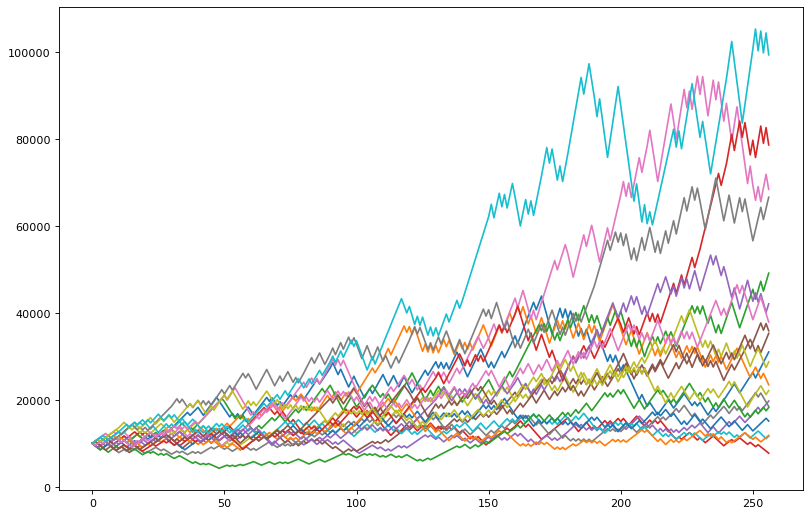

In [463]:
plt.figure(figsize=(12, 8), dpi=80)

ending_bankrolls = []
correct = []
min_bankrolls = []
max_bankrolls = []
bet_size_lst = []

scaler = StandardScaler()
for n in range(20):
    model = MLPClassifier(hidden_layer_sizes=(65,), activation='identity', alpha=0.07)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1275)
    FS_x_train = X_train[feat_names]
    FS_x_test = X_test[feat_names]
    
    scaler.fit(FS_x_train)
    x_trn = scaler.transform(FS_x_train)
    x_tst = scaler.transform(FS_x_test)
    
    model.fit(x_trn, y_train)
    test_pred_values = model.predict(x_tst)
    
    pred = test_pred_values
    actual = np.ravel(y_test)
    
    i = -1
    bankroll = 10000
    bet_size = 500
    bet_size_frac = 0.05

    bet_ind = []
    bankroll_lst = []
    
    broke = False
    while((i+1 < len(pred)) and (broke == False)):
        i += 1
        bet_ind.append(i)
        bankroll_lst.append(bankroll)
        bet_size_lst.append(bet_size)

        if(pred[i] == actual[i]):
            winnings = round(bet_size*0.909091, 2)
            bankroll += winnings
            correct.append(1)
        else:
            bankroll -= bet_size
            correct.append(0)
        bankroll = round(bankroll, 2)

        if((i+1) % 10 == 0):
            bet_size = round(bankroll*bet_size_frac, 2)

        if(bankroll < bet_size):
            broke = True
    
    ending_bankrolls.append(bankroll)
    min_bankrolls.append(min(bankroll_lst))
    max_bankrolls.append(max(bankroll_lst))
    
    plt.plot(bet_ind, bankroll_lst)

print('Starting Bankroll: $10000')
print('Avg Ending Bankroll (256 Games): $' + str(round(sum(ending_bankrolls)/len(ending_bankrolls), 2)))
print('Bet Win %: ' + str(round(sum(correct) / len(correct), 4)))
print('Min Ending Bankroll: $' + str(min(ending_bankrolls)))
print('Max Ending Bankroll: $' + str(max(ending_bankrolls)))
print('Avg Bet Size: $' + str(round(sum(bet_size_lst) / len(bet_size_lst), 2)))

<h2>Identifying High Value Bets: Logistic Regression</h2>

In [ ]:
# Logistic Regression Hyperparameters Tuned:
# - penalty: {'l1', 'l2', 'elasticnet', 'none'}
# - C: Regularization parameter (positive)

In [465]:
scaler = StandardScaler()
model = LogisticRegression(random_state=5)

parameters = dict(penalty=['l1', 'l2', 'elasticnet', 'none'], C=np.arange(0,5,0.1))

search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_log_loss', n_jobs=-1, cv=kf)

pipeline = Pipeline(steps=[('scale', scaler), ('search', search)])
pipeline.fit(X_train, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_